## Corona cases in germany: an analysis

Corona is the hot topic of 2020. Much information and data is available online. Here, we take a deep dive into identified COVID-19 cases in germany. 

### CRISP-DM: Business understanding
We are interested in several questions to gain a better understanding of the dangers of this new disease to the individual, as well as a better understanding to public health response. The questions include:

* Q1: Did public health authorities became quicker or slower in reporting cases?
* Q2: Is it more dangerous to live in a densly-populated city instead of rural areas?
* Q3: Can we predict deaths from case-data?

Thus, we need: data of infections in germany, age-stratified and with county-resolution. This is provided by two csv files; the first one for infection dynamics, and the second one for detailed county information (see below).

In [1]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
#make plots more beautiful

plt.style.use('fivethirtyeight')

## Blogpost: https://medium.com/@deeejy/corona-cases-in-germany-an-analysis-a45ed33d5646

### CRISP-DM: Data Understanding - Exploratory analysis


In [3]:
# import covid infection data from germany
# obtained from Robert Koch Institut (RKI)
# data licensed under DL-DE->BY-2.0
# http://www.govdata.de/dl-de/by-2-0

df = pd.read_csv('RKI_COVID19.csv')
df.head()

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/09/30 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/09/30 00:00:00,0,1,0,Nicht übermittelt
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/10/29 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/10/29 00:00:00,0,1,0,Nicht übermittelt
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/03 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/11/03 00:00:00,0,1,0,Nicht übermittelt
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/20 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/11/19 00:00:00,-9,0,1,Nicht übermittelt
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/23 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/11/18 00:00:00,-9,0,1,Nicht übermittelt


In [4]:
#Translation of column names from german to english
df.rename(columns={"IdBundesland": "IdState", "Bundesland":"State", "Landkreis":"County", "Altersgruppe":"AgeGroup", 
                   "Geschlecht":"Sex", "AnzahlFall":"CaseNumber", "AnzahlTodesfall":"DeathNumber", 
                  "Meldedatum":"DateOfNotice", "IdLandkreis":"IdCounty", "Datenstand":"LastUpdated", 
                   "NeuerFall":"NewCase", "NeuerTodesfall":"NewDeath", "Refdatum":"ReferenceDate", "NeuGenesen":"NewRecovered", 
                   "AnzahlGenesen":"RecoveredNumber", "IstErkrankungsbeginn":"IsDayofSickening", "Altersgruppe2":"AgeGroup2"
                  }, inplace=True)

# drop redundant data and columns w/o relevant information for this project
try:
    df.drop(labels=["FID", "State", "County", "LastUpdated", "AgeGroup2", "NewCase", "NewDeath", "NewRecovered", "RecoveredNumber"], axis=1, inplace=True)
except Exception:
    pass

In [5]:
# IdState & IdCounty: Numerical IDs for state and county
# AgeGroup: binned ages of infected individuals
# CaseNumber/DeathNumber: Number of Cases/Deaths for this entry
# DateOfNotice: Date where federal agency (RKI, basically Germanys CDC) got notified of infection
# ReferenceDate: Either equal to DateofNotice; if not, then this is the date of disease start / symptom onset.
# IsDayofSickening: 1  if ReferenceDate equal symptom onset, 0 else.
display(df.head())
display(df.info())

,ObjectId,IdState,State,County,AgeGroup,Sex,CaseNumber,DeathNumber,DateOfNotice,IdCounty,LastUpdated,NewCase,NewDeath,ReferenceDate,NewRecovered,RecoveredNumber,IsDayofSickening,AgeGroup2
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/09/30 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/09/30 00:00:00,0,1,0,Nicht übermittelt
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/10/29 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/10/29 00:00:00,0,1,0,Nicht übermittelt
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/03 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/11/03 00:00:00,0,1,0,Nicht übermittelt
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/20 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/11/19 00:00:00,-9,0,1,Nicht übermittelt
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/23 00:00:00,1001,"01.12.2020, 00:00 Uhr",0,-9,2020/11/18 00:00:00,-9,0,1,Nicht übermittelt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596804 entries, 0 to 596803
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   ObjectId          596804 non-null  int64 
 1   IdState           596804 non-null  int64 
 2   State             596804 non-null  object
 3   County            596804 non-null  object
 4   AgeGroup          596804 non-null  object
 5   Sex               596804 non-null  object
 6   CaseNumber        596804 non-null  int64 
 7   DeathNumber       596804 non-null  int64 
 8   DateOfNotice      596804 non-null  object
 9   IdCounty          596804 non-null  int64 
 10  LastUpdated       596804 non-null  object
 11  NewCase           596804 non-null  int64 
 12  NewDeath          596804 non-null  int64 
 13  ReferenceDate     596804 non-null  object
 14  NewRecovered      596804 non-null  int64 
 15  RecoveredNumber   596804 non-null  int64 
 16  IsDayofSickening  596804 non-null  int

None

In [6]:
#change date strings to datetime
df['DateOfNotice'] = pd.to_datetime(df['DateOfNotice'], yearfirst=True)
df['ReferenceDate'] = pd.to_datetime(df['ReferenceDate'], yearfirst=True)
# replacing 'unbekannt'(unknown) for nan
df.replace('unbekannt', np.nan, inplace=True)


In [7]:
#checking how many nan values there are in relation to number of entries.

display(df.shape)
df.isna().sum()

(596804, 18)

ObjectId               0
IdState                0
State                  0
County                 0
AgeGroup            2036
Sex                 5600
CaseNumber             0
DeathNumber            0
DateOfNotice           0
IdCounty               0
LastUpdated            0
NewCase                0
NewDeath               0
ReferenceDate          0
NewRecovered           0
RecoveredNumber        0
IsDayofSickening       0
AgeGroup2              0
dtype: int64

#### Due due very low amount of NaN values of age groups and gender (only 1% of rows affected), we can drop these rows without trying to impute values.

In [8]:
df.dropna(inplace=True)
df.shape

(589530, 18)

In [9]:
df.isna().sum()

ObjectId            0
IdState             0
State               0
County              0
AgeGroup            0
Sex                 0
CaseNumber          0
DeathNumber         0
DateOfNotice        0
IdCounty            0
LastUpdated         0
NewCase             0
NewDeath            0
ReferenceDate       0
NewRecovered        0
RecoveredNumber     0
IsDayofSickening    0
AgeGroup2           0
dtype: int64

In [10]:
df.describe()

,ObjectId,IdState,CaseNumber,DeathNumber,IdCounty,NewCase,NewDeath,NewRecovered,RecoveredNumber,IsDayofSickening
count,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000,589530.000000
mean,298238.882126,7.558396,1.792893,0.028172,7889.934909,0.009382,-8.765276,-1.633425,1.278176,0.670473
std,172429.641966,3.287420,2.989913,0.183516,3255.353934,0.100066,1.436623,3.490839,2.058056,0.470042
min,1.000000,1.000000,-6.000000,-1.000000,1001.000000,-1.000000,-9.000000,-9.000000,-2.000000,0.000000
25%,148762.250000,5.000000,1.000000,0.000000,5554.000000,0.000000,-9.000000,0.000000,1.000000,0.000000
50%,298297.500000,8.000000,1.000000,0.000000,8119.000000,0.000000,-9.000000,0.000000,1.000000,1.000000
75%,447158.750000,9.000000,2.000000,0.000000,9478.000000,0.000000,-9.000000,0.000000,1.000000,1.000000
max,596804.000000,16.000000,146.000000,8.000000,16077.000000,1.000000,1.000000,1.000000,146.000000,1.000000


#### Let's check how we can obtain the infection dynamics for one county in germany, and see if the data looks plausible by plotting it. 

,ObjectId,IdState,State,County,AgeGroup,Sex,CaseNumber,DeathNumber,DateOfNotice,IdCounty,LastUpdated,NewCase,NewDeath,ReferenceDate,NewRecovered,RecoveredNumber,IsDayofSickening,AgeGroup2
24,25,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020-03-14,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt
153,154,1,Schleswig-Holstein,SK Flensburg,A35-A59,M,1,0,2020-03-14,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt
90,91,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2020-03-14,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-03-12,0,1,1,Nicht übermittelt
202,203,1,Schleswig-Holstein,SK Flensburg,A35-A59,W,1,0,2020-03-14,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-03-10,0,1,1,Nicht übermittelt
91,92,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2020-03-18,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-03-11,0,1,1,Nicht übermittelt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,153,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2020-11-27,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-11-24,-9,0,1,Nicht übermittelt
263,264,1,Schleswig-Holstein,SK Flensburg,A35-A59,W,1,0,2020-11-27,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-11-25,-9,0,1,Nicht übermittelt
262,263,1,Schleswig-Holstein,SK Flensburg,A35-A59,W,1,0,2020-11-27,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-11-24,-9,0,1,Nicht übermittelt
286,287,1,Schleswig-Holstein,SK Flensburg,A80+,M,1,0,2020-11-29,1001,"01.12.2020, 00:00 Uhr",0,-9,2020-11-29,-9,0,0,Nicht übermittelt


,ObjectId,IdState,CaseNumber,DeathNumber,IdCounty,NewCase,NewDeath,NewRecovered,RecoveredNumber,IsDayofSickening
count,291.000000,291.0,291.000000,291.000000,291.0,291.000000,291.000000,291.000000,291.000000,291.000000
mean,146.000000,1.0,1.096220,0.010309,1001.0,0.003436,-8.907216,-1.010309,0.975945,0.587629
std,84.148678,0.0,0.328559,0.101184,0.0,0.058621,0.910655,2.864148,0.472818,0.493109
min,1.000000,1.0,1.000000,0.000000,1001.0,0.000000,-9.000000,-9.000000,0.000000,0.000000
25%,73.500000,1.0,1.000000,0.000000,1001.0,0.000000,-9.000000,0.000000,1.000000,0.000000
50%,146.000000,1.0,1.000000,0.000000,1001.0,0.000000,-9.000000,0.000000,1.000000,1.000000
75%,218.500000,1.0,1.000000,0.000000,1001.0,0.000000,-9.000000,0.000000,1.000000,1.000000
max,291.000000,1.0,3.000000,1.000000,1001.0,1.000000,0.000000,1.000000,3.000000,1.000000


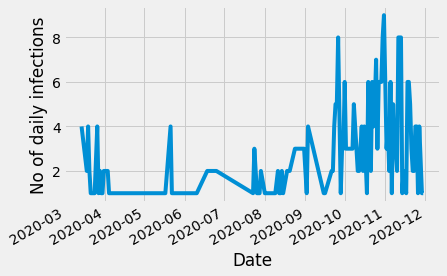

In [11]:
display(df[df['IdCounty']==1001].sort_values(['DateOfNotice']))
df[df['IdCounty']==1001].groupby('DateOfNotice', axis=0).sum()['CaseNumber'].plot()
plt.gca()
plt.xlabel('Date')
plt.ylabel('No of daily infections')
df[df['IdCounty']==1001].describe()

This looks like a plausible infection dynamic, with a clear increase in infections in oct/nov and almost no infections during summer. 
### Question 1 - Analysis
#### There are two dates for every case entry (DateOfNotice and ReferenceDate. We can check their dependence. 

In [12]:
#compile time series of new Cases by DateOfNotice, rolling 7 day average.
ds_casenum = df.groupby('DateOfNotice', axis=0).sum()['CaseNumber'].rolling(window=7, center=True).mean()
ds_casenum_sickening = df[df['IsDayofSickening']==1].groupby('DateOfNotice', axis=0).sum()['CaseNumber'].rolling(window=7, center=True).mean()

In [13]:
#compile time series of new Cases by ReferenceDate, rolling 7 day average. Only include cases where symptom onset is known.
ds_casenumref = df[df['IsDayofSickening']==1].groupby('ReferenceDate', axis=0) \
                .sum()['CaseNumber'].rolling(window=7, center=True).mean()

#compile time series of new Deaths by DateOfNotice, rolling 7 day average.
#ds_deathnum = df.groupby('DateOfNotice', axis=0).sum()['DeathNumber'].rolling(window=7, center=True).mean()

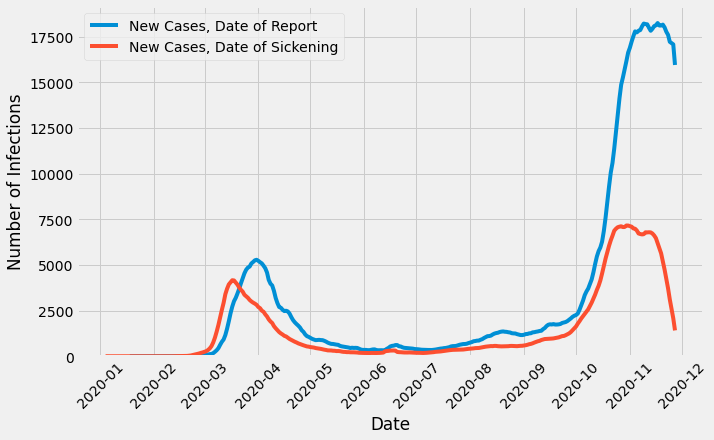

In [14]:
fig, ax = plt.subplots(figsize=(10,6))


ax.plot(ds_casenum.index, ds_casenum, label='New Cases, Date of Report')
ax.plot(ds_casenumref.index, ds_casenumref, label='New Cases, Date of Sickening')
ax.set_ylim(bottom=0)
ax.set_xlabel('Date')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Number of Infections')
ax.legend()
fig.savefig('img/report_vs_sickening.png')

#### It looks like there is a significant lag between Date of Sickening and Date of Report. We are going to evaluate this in more detail in the next cells.

In [15]:
df_sub = df[df['IsDayofSickening']==1]
LagOfNotice = df_sub.apply(lambda row: row.DateOfNotice - row.ReferenceDate, axis=1)
df_sub = df_sub.assign(LagOfNotice = LagOfNotice.values)

In [16]:
def time_delta_to_float(td, unit='d'):
    '''
    Small function to convert a pandas timedelta into a float
    
    Input: 
    td: timedelta 
    unit: either 'd' for days, 'h' for hours, or 'min' for minutes
    
    Output: float.
    '''
    try:
        if unit=='d':
            return float(td.total_seconds()/(24*60*60))
        elif unit=='h':
            return float(td.total_seconds()/(60*60))
        elif unit =='min':
            return float(td.total_seconds()/60)
    except Exception:
        print('input needs to be a pandas timedelta')

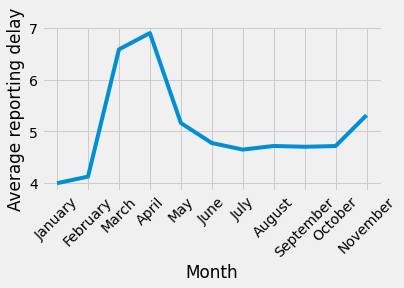

In [17]:
# Data where delay between Sickening and Notice was over 1 month were excluded.
months_single = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']
delay_list = np.zeros(len(months_single))

for i, m in enumerate(months_single):
    delay = df_sub[(df_sub['DateOfNotice'].dt.month==i+1) & (df_sub['LagOfNotice'].dt.days < 32) & (df_sub['LagOfNotice'].dt.days >=0)]['LagOfNotice'].mean()
    #print('The average delay between day of sickening and day of report for cases reported in {} was {}'.format(m, delay))
    delay_list[i] = time_delta_to_float(delay, unit='d')

fig, ax = plt.subplots()
ax.plot(delay_list)
ax.set_xticks(np.arange(len(months_single)))
ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels(months_single)
ax.set_ylabel('Average reporting delay')
ax.set_xlabel('Month')
fig.tight_layout()
fig.savefig('img/report_delay.png')

### Question 1 - Conclusion

#### While reporting delay was high during the first wave (March/April), it was significantly lower in the summer, and is now rising again with the second wave. Clear indication of stressedpublic health authorities.

### Question 2 - Analysis
#### In the data of the original df, an 'IdCounty' field links the cases to the respective county. To see if there is a correlation between county properties and covid cases, we import a second datasheet with detailed county information like its area. 

In [18]:
# import county information. can be merged with df using 'IdCounty'
# using the county_information_df, we can extract cases per 100k
# and possible relationship between numbers of cases and population density
# obtained from Robert Koch Institut (RKI)
# data licensed under DL-DE->BY-2.0
# http://www.govdata.de/dl-de/by-2-0


county_information_df = pd.read_csv('RKI_Corona_Landkreise.csv')
county_information_df=county_information_df[['RS', 'BEZ', 'EWZ', 'county', 'SHAPE_Area']]
county_information_df.rename(columns={'RS': 'IdCounty', 'BEZ':'CountyType', 'EWZ': 'Population', 'SHAPE_Area': 'Area'}, inplace=True)
county_information_df.head()

,IdCounty,CountyType,Population,county,Area
0,1001,Kreisfreie Stadt,90164,SK Flensburg,0.006873
1,1002,Kreisfreie Stadt,246794,SK Kiel,0.015507
2,1003,Kreisfreie Stadt,216530,SK Lübeck,0.028928
3,1004,Kreisfreie Stadt,80196,SK Neumünster,0.009808
4,1051,Kreis,133193,LK Dithmarschen,0.196087


In [19]:
county_information_df.set_index('IdCounty', inplace=True)
pop_density = county_information_df['Population']/county_information_df['Area']
county_information_df['PopDensity'] = pop_density

### county_information_df is the new data frame, that links the IdCounty to the countytype,  population and the population density. It is subsequently merged with the original data frame, grouped by  the IdCounty.

In [20]:
county_information_df.head()

,CountyType,Population,county,Area,PopDensity
IdCounty,,,,,
1001,Kreisfreie Stadt,90164,SK Flensburg,0.006873,1.311911e+07
1002,Kreisfreie Stadt,246794,SK Kiel,0.015507,1.591517e+07
1003,Kreisfreie Stadt,216530,SK Lübeck,0.028928,7.485261e+06
1004,Kreisfreie Stadt,80196,SK Neumünster,0.009808,8.176284e+06
1051,Kreis,133193,LK Dithmarschen,0.196087,6.792530e+05


In [21]:
df_sum_county = df.groupby(['IdCounty'])[['CaseNumber', 'DeathNumber', 'AgeGroup']].sum()

merge_county_df = df_sum_county.merge(county_information_df, left_index=True, right_index=True)
merge_county_df[['CasePer100k']] = merge_county_df['CaseNumber']/merge_county_df['Population']*1e5
merge_county_df[['DeathPer100k']] = merge_county_df['DeathNumber']/merge_county_df['Population']*1e5

merge_county_df.head()

,CaseNumber,DeathNumber,CountyType,Population,county,Area,PopDensity,CasePer100k,DeathPer100k
IdCounty,,,,,,,,,
1001,319,3,Kreisfreie Stadt,90164,SK Flensburg,0.006873,1.311911e+07,353.799743,3.327270
1002,1269,16,Kreisfreie Stadt,246794,SK Kiel,0.015507,1.591517e+07,514.194024,6.483140
1003,1202,6,Kreisfreie Stadt,216530,SK Lübeck,0.028928,7.485261e+06,555.119383,2.770979
1004,461,6,Kreisfreie Stadt,80196,SK Neumünster,0.009808,8.176284e+06,574.841638,7.481670
1051,602,14,Kreis,133193,LK Dithmarschen,0.196087,6.792530e+05,451.975704,10.511063


### Exploratory analysis 
Which correlations do exist in the dataframe?

,CaseNumber,DeathNumber,Population,Area,PopDensity,CasePer100k,DeathPer100k
CaseNumber,1.000000,0.865476,0.924366,-0.113605,0.456657,0.488356,0.119177
DeathNumber,0.865476,1.000000,0.797909,-0.033486,0.234612,0.497220,0.464897
Population,0.924366,0.797909,1.000000,0.035303,0.341415,0.214363,-0.031121
Area,-0.113605,-0.033486,0.035303,1.000000,-0.429705,-0.346526,-0.103949
PopDensity,0.456657,0.234612,0.341415,-0.429705,1.000000,0.373582,-0.040792
CasePer100k,0.488356,0.497220,0.214363,-0.346526,0.373582,1.000000,0.565344
DeathPer100k,0.119177,0.464897,-0.031121,-0.103949,-0.040792,0.565344,1.000000


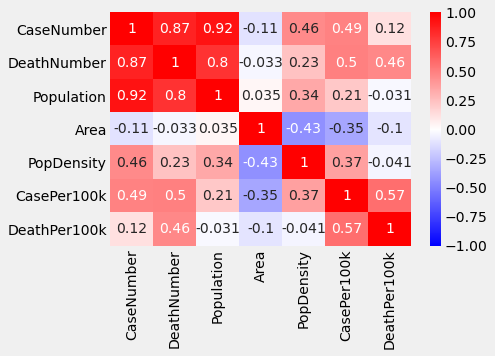

In [22]:
display(merge_county_df.corr())
corrfig = sns.heatmap(merge_county_df.corr(), vmin=-1., vmax=1., cmap='bwr', annot=True)
fig = corrfig.get_figure()
fig.savefig('img/corr.png', bbox_inches='tight')

### Question 2 - Conclusion

#### There seems to be a significant correlation between population density and number of cases per 100k.
#### In contrast, no correlation was found between population density and number of deaths per 100k.

### CRISP-DM: Data Preparation
We now prepare data for further analysis.
We try to predict deaths by means of case and county data; neglecting the date of report.

In [23]:
df= df.set_index('IdCounty')
df_sum = df.groupby(['IdCounty', 'AgeGroup', 'Sex'])[['CaseNumber', 'DeathNumber', 'AgeGroup']].sum()

In [24]:
df_unstack = df_sum.unstack().unstack()
death_sum = df_unstack['DeathNumber'].sum(axis=1)
df_unstack = df_unstack.drop(labels=['DeathNumber'], axis=1)
df_unstack.columns = ['_'.join(col).strip('_') for col in df_unstack.columns]
df_unstack['death_sum'] = death_sum

#nans result from table pivot. no cases in age/sex-group-> nan -> should be zero.
df_unstack.fillna(0, inplace=True)
df_unstack.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum
IdCounty,,,,,,,,,,,,,
1001,5.0,5.0,71.0,54.0,11.0,3.0,3.0,14.0,68.0,72.0,9.0,4.0,3.0
1002,11.0,43.0,264.0,213.0,70.0,16.0,16.0,43.0,244.0,231.0,85.0,33.0,16.0
1003,14.0,47.0,250.0,227.0,62.0,15.0,15.0,48.0,219.0,226.0,59.0,20.0,6.0
1004,9.0,24.0,86.0,85.0,23.0,8.0,10.0,13.0,79.0,79.0,26.0,19.0,6.0
1051,6.0,23.0,82.0,96.0,63.0,26.0,8.0,23.0,91.0,94.0,69.0,21.0,14.0


In [25]:
merge_df = df_unstack.merge(county_information_df, left_index=True, right_index=True)#'IdCounty')#True)#on='IdCounty')
merge_df.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum,CountyType,Population,county,Area,PopDensity
IdCounty,,,,,,,,,,,,,,,,,,
1001,5.0,5.0,71.0,54.0,11.0,3.0,3.0,14.0,68.0,72.0,9.0,4.0,3.0,Kreisfreie Stadt,90164,SK Flensburg,0.006873,1.311911e+07
1002,11.0,43.0,264.0,213.0,70.0,16.0,16.0,43.0,244.0,231.0,85.0,33.0,16.0,Kreisfreie Stadt,246794,SK Kiel,0.015507,1.591517e+07
1003,14.0,47.0,250.0,227.0,62.0,15.0,15.0,48.0,219.0,226.0,59.0,20.0,6.0,Kreisfreie Stadt,216530,SK Lübeck,0.028928,7.485261e+06
1004,9.0,24.0,86.0,85.0,23.0,8.0,10.0,13.0,79.0,79.0,26.0,19.0,6.0,Kreisfreie Stadt,80196,SK Neumünster,0.009808,8.176284e+06
1051,6.0,23.0,82.0,96.0,63.0,26.0,8.0,23.0,91.0,94.0,69.0,21.0,14.0,Kreis,133193,LK Dithmarschen,0.196087,6.792530e+05


In [26]:
# county name not needed for model
merge_df = merge_df.drop(['county'], axis=1)
merge_df.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum,CountyType,Population,Area,PopDensity
IdCounty,,,,,,,,,,,,,,,,,
1001,5.0,5.0,71.0,54.0,11.0,3.0,3.0,14.0,68.0,72.0,9.0,4.0,3.0,Kreisfreie Stadt,90164,0.006873,1.311911e+07
1002,11.0,43.0,264.0,213.0,70.0,16.0,16.0,43.0,244.0,231.0,85.0,33.0,16.0,Kreisfreie Stadt,246794,0.015507,1.591517e+07
1003,14.0,47.0,250.0,227.0,62.0,15.0,15.0,48.0,219.0,226.0,59.0,20.0,6.0,Kreisfreie Stadt,216530,0.028928,7.485261e+06
1004,9.0,24.0,86.0,85.0,23.0,8.0,10.0,13.0,79.0,79.0,26.0,19.0,6.0,Kreisfreie Stadt,80196,0.009808,8.176284e+06
1051,6.0,23.0,82.0,96.0,63.0,26.0,8.0,23.0,91.0,94.0,69.0,21.0,14.0,Kreis,133193,0.196087,6.792530e+05


In [27]:
# Dummy the categorical variables
cat_vars = merge_df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
# for each cat add dummy var, drop original column
    merge_df = pd.concat([merge_df.drop(var, axis=1), pd.get_dummies(merge_df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [28]:
merge_df.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum,Population,Area,PopDensity,CountyType_Kreis,CountyType_Kreisfreie Stadt,CountyType_Landkreis,CountyType_Stadtkreis
IdCounty,,,,,,,,,,,,,,,,,,,,
1001,5.0,5.0,71.0,54.0,11.0,3.0,3.0,14.0,68.0,72.0,9.0,4.0,3.0,90164,0.006873,1.311911e+07,0,1,0,0
1002,11.0,43.0,264.0,213.0,70.0,16.0,16.0,43.0,244.0,231.0,85.0,33.0,16.0,246794,0.015507,1.591517e+07,0,1,0,0
1003,14.0,47.0,250.0,227.0,62.0,15.0,15.0,48.0,219.0,226.0,59.0,20.0,6.0,216530,0.028928,7.485261e+06,0,1,0,0
1004,9.0,24.0,86.0,85.0,23.0,8.0,10.0,13.0,79.0,79.0,26.0,19.0,6.0,80196,0.009808,8.176284e+06,0,1,0,0
1051,6.0,23.0,82.0,96.0,63.0,26.0,8.0,23.0,91.0,94.0,69.0,21.0,14.0,133193,0.196087,6.792530e+05,1,0,0,0


### CRISP-DM: Modeling
### Question 3 - Analysis
Data was finished preparing, we now use a linear regression model to try to predict number of deaths.

In [29]:
X = merge_df.drop('death_sum', axis=1)
y = merge_df['death_sum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [30]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(normalize=True)

In [31]:
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print('Test R2 score of linear regression model is {}'.format(test_score))
print('Train R2 score of linear regression model is {}'.format(train_score))

Test R2 score of linear regression model is 0.8681011711054532
Train R2 score of linear regression model is 0.8569979475915895


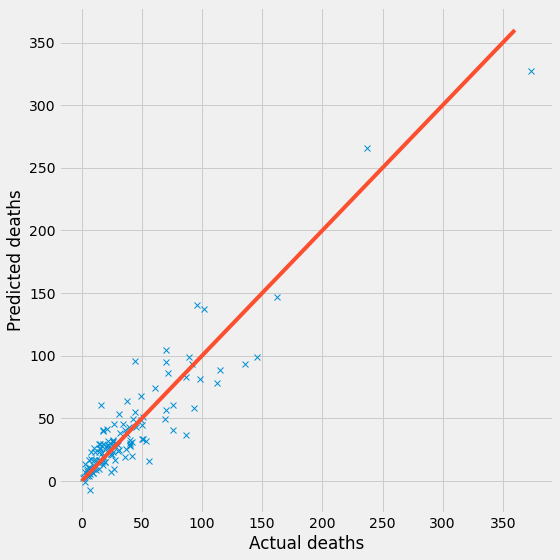

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
x = [0,360]
ax.plot(y_test, y_test_preds, 'x')
ax.set_xlabel('Actual deaths')
ax.set_ylabel('Predicted deaths')
ax.plot(x, x)
fig.tight_layout()
fig.savefig('img/pred_deaths.png')

#### Alternative death prediction
Alternatively, we can predict deaths by simple calculations using the known age- and sex-dependent death rate
The death rate was calculated using the full age and sex-dependent data.
In contrast to that, the linear regression model was fed by the total death number (in the training data set), without knowing its age- and sex-dependency

In [33]:
death_rate_df = df.groupby(['AgeGroup', 'Sex'])[['CaseNumber', 'DeathNumber']].sum()
death_rate = death_rate_df['DeathNumber']/death_rate_df['CaseNumber']
death_rate_df['DeathRate'] = death_rate
death_rate_df

CaseNumber  DeathNumber  DeathRate
AgeGroup Sex                                    
A00-A04  M         10471            2   0.000191
         W          9565            4   0.000418
A05-A14  M         34154            0   0.000000
         W         31365           -1  -0.000032
A15-A34  M        173547           22   0.000127
         W        166610           11   0.000066
A35-A59  M        198456          511   0.002575
         W        208485          205   0.000983
A60-A79  M         74792         3401   0.045473
         W         73352         1580   0.021540
A80+     M         26480         5150   0.194486
         W         49687         5723   0.115181

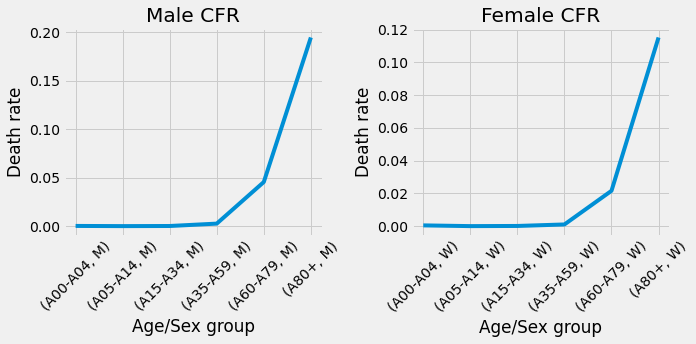

In [34]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

death_rate_df.loc[(slice(None),'M'), :]['DeathRate'].plot(ax=axes[0])
death_rate_df.loc[(slice(None),'W'), :]['DeathRate'].plot(ax=axes[1])

titles = ['Male CFR', 'Female CFR']
for i, ax in enumerate(axes):
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Death rate')
    ax.set_title(titles[i])
    ax.set_xlabel('Age/Sex group')
    
fig.tight_layout()
fig.savefig('img/cfr.png')

The death rate is extremly dependent on age, and also varies with sex. 

With these values, the total death number of the case entries can be predicted, done  in the following cells.

In [35]:
# manual calculation of predicted deaths using death_rate_df and df_sum
df_sum_predict = df_sum.astype('float32').copy()
df_sum_predict[['DeathNumber']] = 0.

for c in np.unique(np.array(df_sum_predict.index.tolist())[:,0]):
    for a in np.unique(np.array(df_sum_predict.index.tolist())[:,1]):
        for s in np.unique(np.array(df_sum_predict.index.tolist())[:,2]):
            try:
                df_sum_predict.loc[(int(c), a, s)]['DeathNumber'] += float(death_rate_df.loc[(a, s)]['DeathRate'] * df_sum_predict.loc[(int(c), a, s)]['CaseNumber'])
            except KeyError:
                continue

In [36]:
df_sum_predict.head()

CaseNumber  DeathNumber
IdCounty AgeGroup Sex                         
1001     A00-A04  M           5.0     0.000955
                  W           3.0     0.001255
         A05-A14  M           5.0     0.000000
                  W          14.0    -0.000446
         A15-A34  M          71.0     0.009000

In [37]:
#calculation of y vector to quickly compare results to our complicated linear regression model. 
#same test/train split (after calculation/prediction, using the prediction y vector!!) to compare results, even though it's obv. not needed here.

df_sum_predict_unstack = df_sum_predict.unstack().unstack()
death_sum_predict = df_sum_predict_unstack['DeathNumber'].sum(axis=1)

y_simple_predict = death_sum_predict.values
_, _, y_train_simple, y_test_simple = train_test_split(X, y_simple_predict, test_size=.3, random_state=42)

### CRISP-DM: Evaluation
### Question 3 - Conclusion

In [38]:
#Score using your model
test_score_simple = r2_score(y_test, y_test_simple)
train_score_simple = r2_score(y_train, y_train_simple)
print('Test R2 score of linear regression model was {}'.format(test_score))
print('Train R2 score of linear regression model was {}'.format(train_score))

print('Test R2 score from the test set of the simple calculation was {}'.format(test_score_simple))
print('Train R2 score from the train set of the simple calculation was {}'.format(train_score_simple))

Test R2 score of linear regression model was 0.8681011711054532
Train R2 score of linear regression model was 0.8569979475915895
Test R2 score from the test set of the simple calculation was 0.8843754991709064
Train R2 score from the train set of the simple calculation was 0.8145241276420384


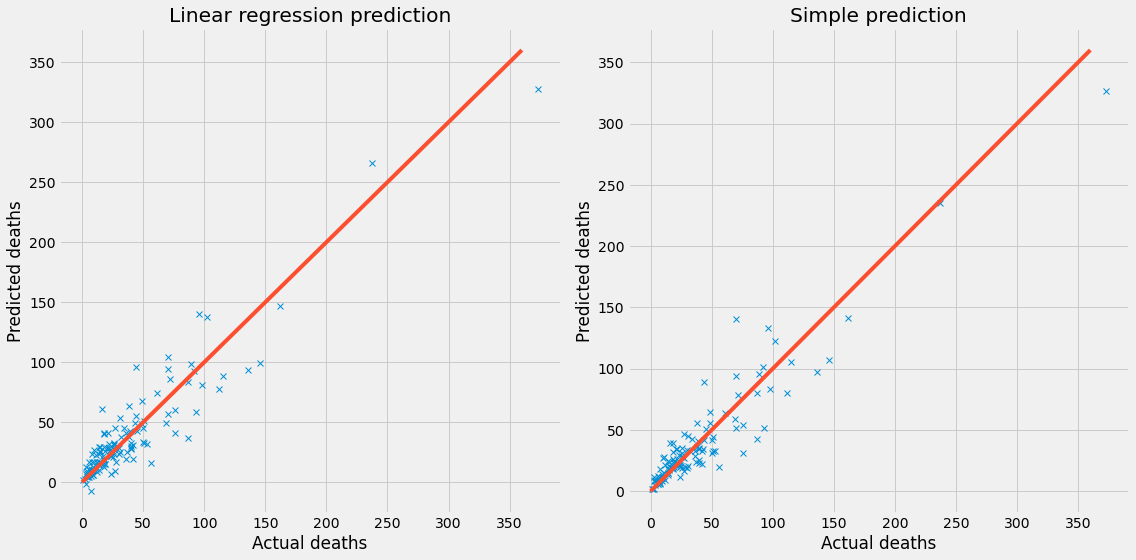

In [39]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
x = [0,360]
data = [y_test_preds, y_test_simple]
titles = ['Linear regression prediction', 'Simple prediction']
for i, ax in enumerate(axes):
    ax.plot(y_test, data[i], 'x')
    ax.set_xlabel('Actual deaths')
    ax.set_ylabel('Predicted deaths')
    ax.set_title(titles[i])
    ax.plot(x, x)
fig.tight_layout()
fig.savefig('img/pred_deaths.png')

It appears as if the linear regression model offers only little benefit over our simplified calculations using only age/sex-dependence. Apparently, these two parameters completly dominate all other parameters, thus there is no drawback of leaving them out. 

Both methods are suitable to predict deaths when only partial information is available